<a href="https://colab.research.google.com/github/ashkree/ICT303_Practical/blob/main/ICT303_Lab3_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ICT303 - Advanced Machine Learning and Artificial Intelligence**
# **Lab 3 - Perceptron and Multilayer Perceptron**

The goal of this lab is to learn how to implement, in a concise way, Linear Regression, Classification, Perceptron and Multilayer Perceptron.

We will first revisit our implementation of the linear regression (linear neuron) model and re-solve it using optimization.


## **1. Solving Linear Regression using Optimization Algorithms**

In the previous tutorial, we  tried to implement from scratch the analytical (closed-form) solution of the linear regression model. In this tutorial, we will use high level deep learning APIs (PyTorch in our case) for its implementation.

Also, instead of implementing the analytical form, we will implement the optmization-based method, using optimizers such as the Gradient Descent Algorithm (SGD) or Adam, which are the most commonly used in deep learning.  

First, we need to import the necessary packages:

In [1]:
import numpy as np
import torch
from torch import nn

### **1.1. Defining the model**

PyTorch provides a base Neural Network module called **Module** and is part of the library **nn**. Think about it as a template. Every neural network you define should extend this class and implement the necessary methods.

In the case of linear regression (simple linear neuron), we define a class called  **LinearRegression** that extends **nn.Module**.

The minimal implementation should contains the following methods (the first two have already been covered in the previous tutorial):
- The constructor **__init__**
- The **forward()** method - used to make a forward pass through the network. In other words, this method takes an input and evaluates the network's output for that input sample,
- The method **loss**, which defines the loss function, and
- The method **configure_optimizers()**, which sets the type of  optimization (i.e., training) algorithm to use to estimate the parameters of the model.




In [2]:
class LinearRegression(nn.Module):

    ## This is the constructor of the class
    def __init__(self, inputSize, outputSize, lr):
        super().__init__()

        self.lr = lr # the learning rate

        # The network is just a linear model
        self.net = nn.Linear(inputSize, outputSize)

    ## The forward step
    def forward(self, X):
      # Computes the output given the input X
      return self.net(X)

    ## The loss function - Here it is the Mean Square Error
    #  It measures the difference between the network output
    #  and the desired (groundtruth) output
    def loss(self, y_hat, y):
      fn = nn.MSELoss()
      return fn(y_hat, y)

    ## The optimization algorithm
    #  Let's use the stochastic gradient descent (SGD)
    def configure_optimizers(self):
      return torch.optim.SGD(self.parameters(), self.lr)


Let's discuss each method in detail.



#### **1.1.1. The constructor**

The role of the constructor `__init__` is to define the architecture of the neural network and set some of the hyper parameters.

In this example, our network is just a linear neuron that takes a certain number of inputs and produces a certain nunmber of outputs. PyTorch provides a class `nn.Linear` that implements this:
```
# Creating a simple linear neuron with takes inputSize inputs and produces outputSize output. The created neuron is saved in self.net
self.net = nn.Linear(inputSize, outputSize)
```
In this example, we have only one hyper parameter, which is the learning rate `lr`:

```
# Setting the learning rate
self.lr = lr
```

Thus, the constructor `__init__` needs to have as input the `inputSize`, the `outputSize` and the learning rate `lr`.


#### **1.1.2. The foward method**

The role of the forward method is to take an input `X`, pass it to the network and return its output. out network is `self.net`. Thus, inside the forward methid, we only need to call `self.net` and with `X` as its input:

```
def forward(self, X):
  # Computes the output given the input X
  return self.net(X)
```



#### **1.1.3. Defining the loss function**

The role of the loss function to measure the error between the output produced by the neural network `self.net` and the groundtruth (i.e., the desired output).

It has two inputs:
- the actual output of the network `y_hat` and
- the desired output `y`.

It should than define which type of loss function will be used and then calls this function to compute the error between `y` and `y_hat`:

```
def loss(self, y_hat, y):
      fn = nn.MSELoss(). # Here we will use the mean square error
      return fn(y_hat, y) # computes the error and returns it
```

#### **1.1.4. Choosing the optimizer**

The last thing is to configure the optimizer. This is done inside the method `configure_optimizers`. In this example, we will use the Stochastic Gradient Descent (SGD) algorithm, which needs as parameter the learning rate `self.lr`:

```
def configure_optimizers(self):
      return torch.optim.SGD(self.parameters(), self.lr)
```


### **1.2. Preparing training data**

To train and test the model, we need data. One option is to collect real data but usually this is time consuming. Alternatively, one can use synthetic data, i.e., data simulated by computer.

To generate synthetic data, we will use the class **SyntheticRegressionData** that we created in the previous lab. Teh class is reproduced here for completeness.

Note that I added a few methods to facilitate its usage.

In [3]:
class SyntheticRegressionData:

  # Implement the constructor of the class
  # We can assume that the constructor also generates some initial data
  def __init__(self): #, w, b, mu = 0.0, sigma = 1.0, noise=0.01, num_train=1000):
    # Generate num_train random samples following Gaussian distribution
    # of mean mu and standard deviation sigma.
    # [self.X, self.y ] = self.generate(mu, sigma, noise, num_train)
    self.n = 0;
    self.w = []
    self.b = []

  def generate(self, w, b, mu = 0.0, sigma = 1.0, noise=0.01, num_train=1000):

    self.n = num_train   # no. of trianing samples
    self.w = w
    self.b = b

    self.mu = mu
    self.sigma = sigma

    # Generate num_train random samples following Gaussian distribution
    # of mean mu and standard deviation sigma.
    self.X = mu +  torch.randn(len(self.w), self.n) * sigma

    # Let's corrupt the data with some random noise
    noise = torch.randn(1, self.n) * noise

    # For each sample in X, generate its corresponding y value
    # using the equation above.
    # Note below that the function reshape has parameters (-1, 1).
    # This means that it will reshape the vector w into a 2D matrix where:
    # - the 2nd dimension has length 1
    # - the length of the first dimension will be autmatically set.
    #
    self.y = torch.matmul(w.reshape((-1, )), self.X) + b + noise
    self.y = torch.transpose(self.y, 0, 1)

    return self.X, self.y

  def dim(self):
    # Return the dimension of the input data
    return self.X.size(dim=0)

  def dimOutput(self):
    return self.y.size(dim=1)

### **1.3. Training process**

Here, we need to update the **Trainer** that we created in the last lab. In particular, the important method of this class is the method ***fit()***, which finds the best parameters of the model given the training data. It has as input:
- The machine learning model **model**. In our case, this will be an instance of the class **LinearRegression**
- The training **data**. The data should include input samples (**data.X**) and their corresponding desired (groundtruth) output (**data.Y**). The latter is often referred to as labels. Note that in the example below, I am assuming that each column of **data.X** is a data sample (following the convention we had in the lecture and in the previoous lab).


The method **fit** will then iterate `max_epochs` times. At each iteration, it will call the method **fit_epoch**  whose role is to:
- Go through all the input data, feed them to the network and collect the computed output
- Compare, using the loss function, the discrepancy between the computed output and the groundtruth output
- Compute the gradient of the loss function and backpropagate it to all the layers of the network using the function `loss.backward()`,
- Update the values of the network parameters using the function `self.optimizer.step()`.

Note that prior to the computation of the loss and gradient, we had to call the function `self.optimizer.zero_grad()`. This clears gradient buffers because we do not want any gradient from previous epoch to carry forward.

The entire code of the class is given below. Note that we also provide here the function `fit_naive`, which is the implementation we did last week.

In [4]:
class Trainer:

  # The constructor of the class
  # It is used to set some basic training parameters (e.g., no. of epochs)
  def __init__(self, n_epochs = 3):
    self.max_epochs = n_epochs
    return

  ## Training method: it uses iterative optimization
  #  This one is generic, i.e., it should work with any regresssion (linear or non-linear)
  def fit(self, model, data):

    # configure the optimizer
    self.optimizer = model.configure_optimizers()

    for epoch in range(self.max_epochs):
      self.fit_epoch(data)

  def fit_epoch(self, data):
    inputs = torch.transpose(data.X, 0, 1) # this makes each row as a data sample
    labels = data.y

    # Clear gradient buffers because we don't want any gradient from previous
    # epoch to carry forward, dont want to cummulate gradients
    self.optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = model.loss(outputs, labels)

    # get gradients w.r.t the parameters of the model
    loss.backward()

    # update the parameters
    self.optimizer.step()

  ## Training method - Previous implementation (previous lab)
  #  This is the naive implementation, included here for comparison
  #  Only works with nonlinear regression
  def fit_naive(self, model, data):
    # 2.1. Add 1 at the end of X
    ones = torch.ones(1, data.n)  # a column vector of ones
    X = torch.cat((data.X, ones), 0)

    # 2.2. The solution
    A = torch.matmul(X, torch.transpose(X, 0, 1))
    # A should be of size num_train x num_train. To check it, uncomment the following
    # print(A.size())

    B = torch.matmul(torch.inverse(A), X) #torch.transpose(X, 0, 1))
    # print(B.size())

    w_estimated = torch.matmul(B, data.y)
    # print(w_estimated .size())

    model.w = w_estimated[0:-1]    # get all the elements except the last one
    model.b = w_estimated[-1:]     # last element


### **1.4. Putting all things together**

Now that we have all classes in places, we need to write the main program that uses these classes to:
- Create synthetic data,
- Define the machine learning mdoel (Linear Regression in our case),
- Train the model,
- Evaluate its performance.

In [5]:
# 1. Generating some synthetic data
d = 1   # dim of the data
w = torch.tensor([2.0, 3.1])
b = 4.2
num_train = 100
noise = 0 #1.2
mu = 0
sigma = 1.2

data_generator = SyntheticRegressionData()
data_generator.generate(w, b, mu=mu, sigma = sigma, noise = noise, num_train = num_train)

inputSize = data_generator.dim()
outputSize= data_generator.dimOutput()

# 2. Creating the machine learning model
model = LinearRegression(inputSize, outputSize, lr=0.03)

# 3. Training the network
# 3.1. Creating the trainer class
trainer = Trainer(n_epochs=100)

# 3.2. Training the model
print(inputSize)
print(outputSize)

trainer.fit(model, data_generator)

# 4. Get the results
w_star = model.net.weight
b_star = model.net.bias

# print(w_estimated)
print("Estimated W: ", w_star)
print("Estimate b: ",  b_star)

# real values
print("Real W: ", w)
print("Real b: ", b)


2
1
Estimated W:  Parameter containing:
tensor([[2.0039, 3.0994]], requires_grad=True)
Estimate b:  Parameter containing:
tensor([4.1907], requires_grad=True)
Real W:  tensor([2.0000, 3.1000])
Real b:  4.2


**Questions:**
- What are the parameters of the model?
- What are the hyper parameters of the model?

### **1.3. Exercise 1**

Try to change the number of epochs, by starting with a small value, e.g., 2 and then increase it to 10, 50, 75 and 100. Then observe the effect on the result.

Now, set the maximum number of epochs to 100 and
- vary the number of traning samples, from a small number to a large one, and observe the results.
- vary the learning rate, e.g., by trying small values and large values. What do you observe?

## **2. Multilayer Perceptron**

Now that we have seen how to create a neuron that implements a linear regression, it is time to scale up and build our first Multilayer Perceptron (MLP) using PyTorch.

Implementing an MLP with PyTorch involves the following steps:
- Importing all dependencies
- Defining the neural network class, let's call it **MLP**, as a subclass of **nn.Module** in the same way we did for the linear regression model.
- Preparing the data set - in this example, let's use the **CIFAR-10** dataset, which consists of $60$K colour images (of size $32\times32$) divided into $10$ classes, with $6000$ images per class. There are $50$K training images and $10$K test images.
- Initializing the loss function and optimizer.
- Defining the custom training loop, where all the magic happens.

CIFAR-10 dataset has $10$ classes of objects (e.g., airplane, automobile, birdt, cat, etc.).

### **2.1. Dependencies**

We will need to import:
- PyTorch.
- From it we import **nn**, which allows us to define a neural network module.
- The **DataLoader** so that we can feed data into the MLP during training. In this example, we will use the CIFAR10 dataset.
- transforms, which allows us to perform transformations on the data prior to feeding it to the MLP. We will discuss more about the utility of this step.

In [6]:
# Importing all dependencies
import os # for some OS ops
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

from torchvision.datasets import CIFAR10  # The data set that we will use

import matplotlib.pyplot as plt
import numpy as np



### **2.2. Defining the MLP neural network**

The input to the network are images of size $32\times32$ from CIFAR-10. Each pixel is represented with three values that encode the Red, Green and Blue component of the RGB color. Thus, the input to the MLP is a vector of size $32 \times 32 \times 3$. In this case, the input layer of the MLP will have $32 \times 32 \times 3 = 3072$ neurons.

We would like the MLP to recognise each of the $10$ object classes. Thus, the output layer needs to have $10$ neurons.

The number of intermediate layers as well as the number of neurons in each of the intermediate layers are hyper parameters that one needs to define and tune. These can be done either by experience or experimentally (try different values and pick up the best). In this example, we will use two hidden layers of size $64$ and $32$, respectively. Each of the hidden layers will be followed by a ReLU activation function.

In [7]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, inputSize=32 * 32 * 3, outputSize=10, lr=0.01):
    super().__init__()

    # The network architecture
    self.net = nn.Sequential(
      nn.Flatten(),
      nn.Linear(inputSize, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, outputSize),
    )
    # Setting the learning rate
    self.lr = lr

  ## The forward step
  def forward(self, X):
    # Computes the output given the input X
    return self.net(X)

  ## The loss function - Here, we will use Cross Entropy Loss
  def loss(self, y_hat, y):
    fn = nn.CrossEntropyLoss() # see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    return fn(y_hat, y)

  ## The optimization algorithm
  #  Let's this time use Adam, which is the most commonly used optimizer in neural networks
  def configure_optimizers(self):
    # return torch.optim.SGD(self.parameters(), self.lr)
    return torch.optim.Adam(self.parameters(), self.lr)


Note that we have only changed two things changed compared to the **LinearRegression** class:
- the definition of the network layers in the method **__init__**, and
- the method **forward()**.

Since it is a classification problem, here we use the Cross Entropy Loss.

For the optimizer, we could also use SGD optimizer, but Adam is the most popular in deep learning.

### **2.3. The training loop**

Here again, we will use. the class Trainer, which we reproduce here for clarity. Below, we discuss the necessary changes that need to be made.

In [8]:
class Trainer:

  def __init__(self, n_epochs = 3):
    self.max_epochs = n_epochs
    return

  # The fitting step
  def fit(self, model, data):

    self.data = data

    # configure the optimizer
    self.optimizer = model.configure_optimizers()
    self.model     = model

    for epoch in range(self.max_epochs):
      self.fit_epoch()

    print("Training process has finished")

  def fit_epoch(self):

    current_loss = 0.0

    # iterate over the DataLoader for training data
    # This iteration is over the batches
    # For each batch, it updates the network weeights and computes the loss
    for i, data in enumerate(self.data):
      # Get input aand its corresponding groundtruth output
      inputs, target = data

      # Clear gradient buffers because we don't want any gradient from previous
      # epoch to carry forward, dont want to cummulate gradients
      self.optimizer.zero_grad()

      # get output from the model, given the inputs
      outputs = self.model(inputs)

      # get loss for the predicted output
      loss = self.model.loss(outputs, target)

      # get gradients w.r.t the parameters of the model
      loss.backward()

      # update the parameters (perform optimization)
      self.optimizer.step()

      # Let's print some statisics
      current_loss += loss.item()
      if i % 500 == 499:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 500))
          current_loss = 0.0

### **2.4. The main program**
The main program to train the neural network looks as follows:

In [9]:
# 1. Loading the CIFAR-10 data set
# Transforms to apply to the data - More about this later
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Loading the data
train_dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=transform)

# If you would like to see the list of classes, uncomment the line below
# print(train_dataset.classes)

batch_size = 10
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=1)

# 2. The MLP model
mlp_model = MLP(lr=1e-04)

# 3. Training the network
# 3.1. Creating the trainer class
trainer = Trainer(n_epochs=1)

# 3.2. Training the model
trainer.fit(mlp_model, trainloader)


100%|██████████| 170M/170M [00:06<00:00, 25.3MB/s]


Loss after mini-batch   500: 2.098
Loss after mini-batch  1000: 1.889
Loss after mini-batch  1500: 1.777
Loss after mini-batch  2000: 1.753
Loss after mini-batch  2500: 1.716
Loss after mini-batch  3000: 1.695
Loss after mini-batch  3500: 1.670
Loss after mini-batch  4000: 1.655
Loss after mini-batch  4500: 1.649
Loss after mini-batch  5000: 1.620
Training process has finished


### **2.5. Testing the trained model**

Once trained, the network needs to be tested on images that the network hasn't seen during training. In other words, the test images should be different from those used for training.  

We do this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

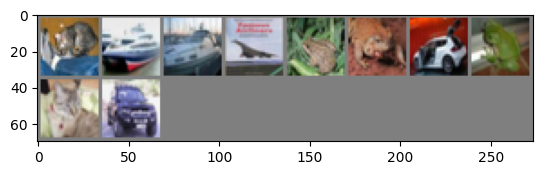

GroundTruth:  cats  ships ships airplanes frogs frogs cars  frogs cats  cars 
Estimated Labels:  cats  ships ships ships frogs frogs cats  frogs dogs  cars 


In [11]:
'''
# printing some info about the dataset
print("Number of points:", dataset.shape[0])
print("Number of features:", dataset.shape[1])
print("Features:", dataset.columns.values)
print("Number of Unique Values")
for col in dataset:
    print(col,":",len(dataset[col].unique()))
plt.figure(figsize=(12,8))
'''

classes = ('airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'truck')
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

testset = CIFAR10(os.getcwd(), train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)

dataiter = iter(testloader)
images, labels = next(dataiter)  # this gets one batch
# print(images.shape[0]) # should be equal to batch_size
# print(labels)  # the labels of the images in the batch


# Let's see some images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(images.shape[0])))

# Now, let's see what the network thinks these examples are
output = mlp_model(images)
estimated_labels = torch.max(output, 1).indices
#print(estimated_labels)
#print(labels)

print('Estimated Labels: ', ' '.join(f'{classes[estimated_labels[j]]:5s}' for j in range(images.shape[0])))


##  **3. Exercise 2**

Change the number of layers in the network we defined above and observe how the network is performing. Also, compare the computation time, i.e., how long it takes to train when you increase the number of layers.

Try also to increase the number of neurons in the intermediate layers of your network.

**Question:** Does increasing, undefinitely, the number of layers and the number of neuron per layer always improves classification accuracy?

##  **4. Exercise 3 - MNIST dataset**

In this exercise, you are required to build a neural network (a MLP) in PyTorch and train it to recognize handwritten digits from the MNIST dataset.

Instead of using the class CIFAR10 to load the data, you can use MNIST. Once the training set is loaded, please check:
- the resolution of each image,
- the number of images in each training set and
- the number of classes (can you guess how many classes the dataset will contain??).

Then design an MLP by setting the adequate number of input and output neurons. The number of layers and the number of neurons in each hidden layer are hyperparameters, which you can play with and observe the performance.

##  **5. Exercise 4 - Forward thoughts**

What do you think about:
- the way we are currently evaluating the performance?
- the way we are choosing the different hyperparameters?

Can you think of a better way to streamline this and make it more rigorous?